# Interaction network: miRNA-RNA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from scipy.stats import spearmanr

## Load data

In [3]:
# Load significant miRNAs associated to treatments, divided into modules
path_miRNA = 'WGCNA_miRNA/output/'
file_list = ['significant_genes_black_data.GEMTAX.vs.all.txt',
    'significant_genes_blue_data.VSGT.vs.all.txt',
    'significant_genes_brown_data.VSGT.vs.all.txt',
    'significant_genes_red_data.VSGT.vs.all.txt',
    'significant_genes_yellow_data.VSGT.vs.all.txt']
 
miRNA_data = {} 
 
for value in file_list:
    with open(path_miRNA + value, "r", encoding="utf-8") as file:
        miRNA_data['miRNA_'+value.split('_')[2]+'_'+value.split('.')[1].replace('GEMTAX', 'GT')] = [x.replace('\n', '').replace('.', '-') for x in file.readlines()]  
 
miRNA_data.keys()

dict_keys(['miRNA_black_GT', 'miRNA_blue_VSGT', 'miRNA_brown_VSGT', 'miRNA_red_VSGT', 'miRNA_yellow_VSGT'])

In [4]:
# Load significant GENES associated to treatments, divided into modules
path_RNA = 'WGCNA_mRNA/output/'
file_list1 = [
    'significant_genes_green_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_greenyellow_data.VPA.vs.all.txt',
    'significant_genes_magenta_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_pink_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_red_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_tan_data.GEMTAX.vs.all.txt',
    'significant_genes_tan_data.VPA_SIM.vs.all.txt'
]
 
RNA_data = {} 
 
for value in file_list1:
    with open(path_RNA + value, "r", encoding="utf-8") as file:
        RNA_data['RNA_'+value.split('_')[2]+'_'+value.split('.')[1].replace('VS_GEMTAX', 'VSGT').replace('VPA_SIM', 'VS').replace('GEMTAX', 'GT')] = [x.replace('\n', '').replace('.', '-') for x in file.readlines()]  
RNA_data.keys()

dict_keys(['RNA_green_VSGT', 'RNA_greenyellow_VPA', 'RNA_magenta_VSGT', 'RNA_pink_VSGT', 'RNA_red_VSGT', 'RNA_tan_GT', 'RNA_tan_VS'])

In [5]:
# load DB with miRNA targets
mirna_db = pd.read_csv('data/miRTarBase_MTI.csv')

# Keep only homo sapiens and drop duplicated rows
print(mirna_db.shape)
mirna_db_hsa = mirna_db[mirna_db['Species (miRNA)']=='hsa'].drop_duplicates() 
print(mirna_db_hsa.shape)

# Keep only targets witha Stong Support
mirna_db_hsa_strong = mirna_db_hsa[np.logical_not(mirna_db_hsa['Support Type'].str.contains('Weak'))]
print(mirna_db_hsa_strong.shape)
print('Number of miRNA: ', len(mirna_db_hsa.miRNA.unique().tolist()))
print('Number of miRNA strong: ', len(mirna_db_hsa_strong.miRNA.unique().tolist()))
mirna_db_hsa_strong_func = mirna_db_hsa_strong[mirna_db_hsa_strong['Support Type']=='Functional MTI']
print('Number of miRNA strong & functional: ', len(mirna_db_hsa_strong_func.miRNA.unique().tolist()))

(4671966, 9)
(1859322, 9)
(15211, 9)
Number of miRNA:  3056
Number of miRNA strong:  1024
Number of miRNA strong & functional:  1021


## Interaction network miRNAs and genes in interesting modules (edges based on correlation in the data)

In [6]:
print('Number of miRNA in the red module:', len(miRNA_data['miRNA_red_VSGT']))
print('Number of miRNA in the yellow module:', len(miRNA_data['miRNA_yellow_VSGT']))
miRNA_red_yellow_VSGT = miRNA_data['miRNA_red_VSGT'] + miRNA_data['miRNA_yellow_VSGT']
len(miRNA_red_yellow_VSGT)

Number of miRNA in the red module: 18
Number of miRNA in the yellow module: 34


52

In [7]:
print('Number of genes in the module:', len(RNA_data['RNA_red_VSGT']))

Number of genes in the module: 554


### Load counts data

In [8]:
# Load significant miRNAs associated to treatments, divided into modules
mirna_data_path = 'WGCNA_miRNA/data/' 
rna_data_path = 'WGCNA_mRNA/data/'

mirna_counts = pd.read_csv(mirna_data_path+'mature_counts.csv').set_index('Unnamed: 0').T.sort_index(axis=1)
rna_counts = pd.read_csv(rna_data_path+'salmon.merged.gene_counts.tsv', sep='\t')
rna_counts.columns = [x.replace('VPA_SIM', 'VPASIM').replace('VS_GEMTAX', 'VSGT') for x in rna_counts.columns]

In [9]:
# The three modules (1 for mRNAs and 2 for miRNAs) we are considering in the following analyses
rna_counts_red = rna_counts[rna_counts.gene_id.isin(RNA_data['RNA_red_VSGT'])].drop(columns='gene_id').set_index('gene_name')
mirna_counts_red_yellow = mirna_counts.loc[miRNA_red_yellow_VSGT]

In [10]:
# Nomalization of miRNA and RNA counts with log10
mirna_counts_norm = np.log10(mirna_counts_red_yellow + 1e-5)
rna_counts_norm = np.log10(rna_counts_red + 1e-5)

In [11]:
# Check if there is a normal distribution in the normalized data -> check norm on rows since we want to compare genes and not samples
from scipy.stats import normaltest
print('miRNA p<0.05 normality: ', normaltest(mirna_counts_norm, axis=1).pvalue < 0.05)
print('mRNA p<0.05 normality: ', normaltest(rna_counts_norm, axis=1).pvalue < 0.05)

miRNA p<0.05 normality:  [False False False False False False False False False False False False
 False False  True False False False False False False False  True False
  True False False False False False False False False False False False
  True  True False False False False False False False False  True False
 False False  True  True]
mRNA p<0.05 normality:  [False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False 

### Calculate correlation between miRNA and targets

/g100_work/ELIX5_fratelli/CellLines_Remedi4All/remedi4all_env/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/g100_work/ELIX5_fratelli/CellLines_Remedi4All/remedi4all_env/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


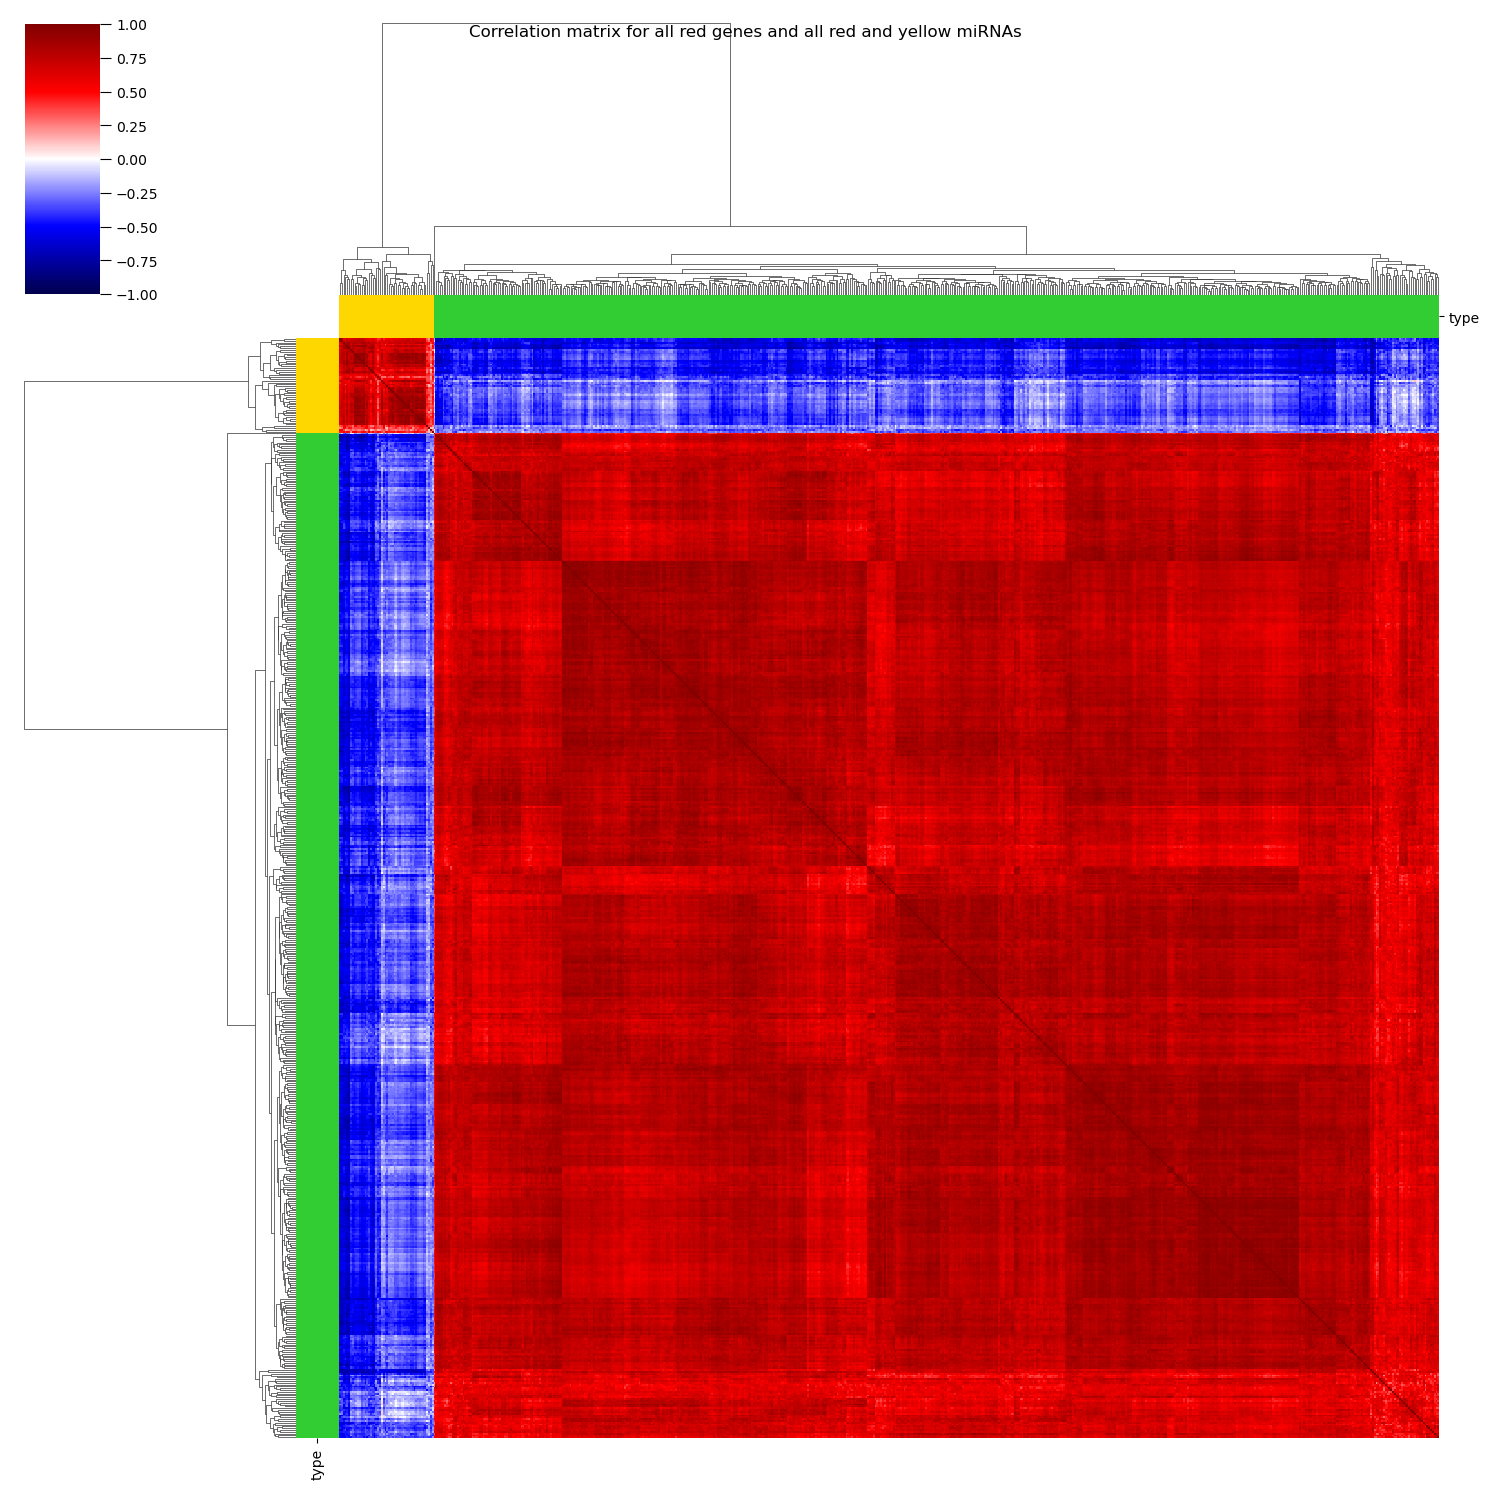

In [12]:
rna4corr = rna_counts_norm
rna4corr['type'] = 'limegreen'
mirna4corr = mirna_counts_norm
mirna4corr['type'] = 'gold'
df4corr = pd.concat([rna4corr, mirna4corr]).T
df_corr = df4corr.drop('type').corr(method='spearman')

sns.clustermap(df_corr, vmin=-1, vmax=1, cmap='seismic', figsize=(15, 15), 
               row_colors=df4corr.loc['type', ], col_colors=df4corr.loc['type', ], yticklabels=False ,xticklabels=False)
plt.tick_params(axis='y', direction='out', length=8)
plt.suptitle('Correlation matrix for all red genes and all red and yellow miRNAs')
plt.show()

### Create total graph

In [13]:
weights_list = []
# Create an empty graph
F = nx.Graph()

# Node name list
nodes = list(df4corr.columns)

# Add nodes to graph
for i, node in enumerate(nodes):
    F.add_node(node, 
               color='gold' if 'hsa-' in node else 'limegreen')

# Add edges to the graph
for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i < j:  
            weight = df_corr.iloc[i, j]
            weights_list.append(weight)
            F.add_edge(node1, node2, 
                       weight=weight, 
                       abs_weight=np.abs(weight), 
                       color='indianred' if weight>0 else 'cornflowerblue',
                       width=np.abs(weight)*100)
                
print('Number of total edges:', F.number_of_edges())
print('Number of total nodes:', F.number_of_nodes())

Number of total edges: 183315
Number of total nodes: 606


In [14]:
# Compute degree centrality for each node
degree_dict = dict(F.degree(weight='abs_weight'))
df_centrality = pd.DataFrame(pd.DataFrame({
    'degree': degree_dict,
}))

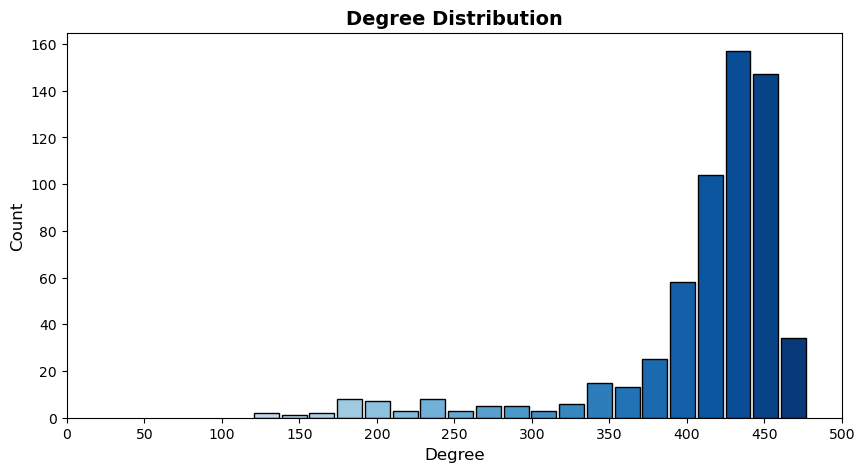

In [15]:
# Compute histogram data
counts, bins = np.histogram(df_centrality.degree, bins=20)

# Normalize bin positions for color intensity
colors = [plt.cm.Blues(i / max(bins)) for i in bins]  

# Adjust figure size 
fig, ax = plt.subplots(figsize=(10, 5)) 

# Plot histogram bars with adjustable bar width
bar_width = (bins[1] - bins[0]) * 0.9  
for i in range(len(bins) - 1):
    ax.bar(bins[i], counts[i], width=bar_width, color=colors[i], edgecolor='black')

ax.grid(False)
ax.set_title("Degree Distribution", fontsize=14, fontweight='bold')
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Extend the x-axis to 500
ax.set_xlim(0, 500)

# Adjust xticks
xticks = range(0, 501, 50)  
ax.set_xticks(xticks)

plt.show()

#### Sub-graph by filtering edges and nodes using percentiles

1) Filter edges

In [16]:
# Filter edges
# Extract only the values above the diagonal (excluding the diagonal)
upper_triangle_values = np.array(df_corr)[np.triu_indices_from(np.array(df_corr), k=1)]
# Calculate the 95th percentile and the 5th percentile to have only the reports with higher positive and negative values (we keep 10% of the reports in total)
percentile_95_edge = np.percentile(upper_triangle_values, 95)
print("95° percentile:", percentile_95_edge)
percentile_5_edge = np.percentile(upper_triangle_values, 5)
print("5° percentile:", percentile_5_edge)

95° percentile: 0.8910452353949153
5° percentile: -0.4502084129524474


2) Filter nodes

In [17]:
# Filter nodes
percentile_90_gene = np.percentile(df_centrality.loc[np.logical_not(df_centrality.index.str.contains('hsa')), 'degree'], 90)
genes2plot = df_centrality.loc[(np.logical_not(df_centrality.index.str.contains('hsa'))) & (df_centrality.degree > percentile_90_gene)].index.tolist()
print('Number of filtered mRNAs:', len(genes2plot))

percentile_50_miRNA = np.percentile(df_centrality.loc[df_centrality.index.str.contains('hsa'), 'degree'], 50)
mirna2plot = df_centrality.loc[(df_centrality.index.str.contains('hsa')) & (df_centrality.degree > percentile_50_miRNA)].index.tolist()
print('Number of filtered miRNAs:', len(mirna2plot))

Number of filtered mRNAs: 56
Number of filtered miRNAs: 26


In [18]:
# Create a txt file with the mRNA in the sub-graph 
with open('output/genes4string.txt', 'w') as f:
    for item in genes2plot:
        f.write(f"{item}\n")

In [19]:
# Create a list of all the predicted targets of miRNA2plot to plot them differently
pred_targets_tot = mirna_db_hsa_strong_func.loc[mirna_db_hsa_strong_func.miRNA.isin(mirna2plot), 'Target Gene'].tolist()
len(pred_targets_tot)

754

In [20]:
# Create the sub-graph
weights_list_G = []
weights_list_soglia_G = []
df_corr_filt = df_corr.loc[df_corr.columns.isin(genes2plot+mirna2plot), df_corr.columns.isin(genes2plot+mirna2plot)]

# Crea an empty graph
G = nx.Graph()

# Node name list
nodes = df_corr_filt.columns.tolist()

# Add nodes to the graph        
for i, node in enumerate(nodes):
    G.add_node(node, 
               color='gold' if 'hsa-' in node else 'limegreen', )

# Add edges to the graph
for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i < j:  
            weight = df_corr_filt.iloc[i, j]
            weights_list_G.append(weight)
            if (weight > percentile_95_edge) | (weight < percentile_5_edge):
                weights_list_soglia_G.append(weight)
                G.add_edge(node1, node2, 
                           weight=weight, abs_weight=np.abs(weight), 
                           color='indianred' if weight>0 else 'cornflowerblue',
                           group='indianred' if weight>0 else 'cornflowerblue',
                           width=np.abs(weight)*100)
                
print('Number of total edges:', G.number_of_edges())
print('Number of total nodes:', G.number_of_nodes())

Number of total edges: 1937
Number of total nodes: 82


In [21]:
# Display the sub-graph
subnet = Network(directed=False) 
subnet.from_nx(G) 

for n in subnet.nodes:
    if n['label'] in pred_targets_tot:
        n['shape'] = 'triangle'
        n['color'] = 'teal'
    else:
        n['shape'] = 'dot'
    n['label'] = n['label'].replace('hsa-', '').replace('-', '.')
    n['borderWidth'] = 1
    n['group'] = 1 if n['color']=='gold' else 2
    n['color'] = {'border': 'grey', 'background': n['color']}
    n['size'] = 20

subnet.force_atlas_2based(gravity=-5, central_gravity=0.005, spring_length=200, spring_strength=0.01)
subnet.show_buttons()
subnet.save_graph("network_plot/subgraph_tot.html")

#### Sub-graph by filtering edges and nodes using deseq results

In [22]:
df_mRNA_deseq = pd.read_excel('/g100_work/ELIX5_fratelli/Mice_Remedi4All/RNA_mice/data/transcriptomics_results_tables.xlsx')

In [23]:
df_VSGTvC = pd.read_excel('/g100_work/ELIX5_fratelli/Mice_Remedi4All/miRNA_mice/data/miRNA_lncRNA_results.xlsx', sheet_name='miRNA_VSGT_v_CTRL')

In [24]:
list_nodes_DE = df_mRNA_deseq.loc[df_mRNA_deseq['padj_VS_GEMTAX_vs_CTR']<0.05, 'GENESYMBOL'].tolist() + df_VSGTvC.miR_ID.tolist()

In [25]:
# Create the sub-graph
weights_list_H = []
weights_list_soglia_H = []
df_corr_filt_H = df_corr.loc[df_corr.columns.isin(list_nodes_DE), df_corr.columns.isin(list_nodes_DE)]

# Crea an empty graph
H = nx.Graph()

# Node name list
nodes = df_corr_filt_H.columns.tolist()

# Add nodes to the graph        
for i, node in enumerate(nodes):
    H.add_node(node, 
               color='gold' if 'hsa-' in node else 'limegreen', )

# Add edges to the graph
for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i < j:  
            weight = df_corr_filt_H.iloc[i, j]
            weights_list_H.append(weight)
           # if (weight > percentile_95_edge) | (weight < percentile_5_edge):
            weights_list_soglia_H.append(weight)
            H.add_edge(node1, node2, 
                        weight=weight, abs_weight=np.abs(weight), 
                        color='indianred' if weight>0 else 'cornflowerblue',
                        group='indianred' if weight>0 else 'cornflowerblue',
                        width=np.abs(weight)*100)
                
print('Number of total edges:', H.number_of_edges())
print('Number of total nodes:', H.number_of_nodes())

Number of total edges: 87153
Number of total nodes: 418


In [26]:
# Compute degree centrality for each node IN THE SUB-GRAPH
degree_dict = dict(H.degree(weight='abs_weight'))
df_centrality_DE = pd.DataFrame(pd.DataFrame({
    'degree': degree_dict,
}))

2) Filter nodes

In [27]:
# Filter nodes
percentile_90_gene = np.percentile(df_centrality_DE.loc[np.logical_not(df_centrality_DE.index.str.contains('hsa')), 'degree'], 90)
genes2plotDE = df_centrality_DE.loc[(np.logical_not(df_centrality_DE.index.str.contains('hsa'))) & (df_centrality_DE.degree > percentile_90_gene)].index.tolist()
print('Number of filtered mRNAs:', len(genes2plotDE))

percentile_50_miRNA = np.percentile(df_centrality_DE.loc[df_centrality_DE.index.str.contains('hsa'), 'degree'], 50)
mirna2plotDE = df_centrality_DE.loc[(df_centrality_DE.index.str.contains('hsa')) & (df_centrality_DE.degree > percentile_50_miRNA)].index.tolist()
print('Number of filtered miRNAs:', len(mirna2plotDE))

Number of filtered mRNAs: 38
Number of filtered miRNAs: 22


Intersection with nodes filtered only on degree centrality, not DE results

In [28]:
len(np.intersect1d(genes2plotDE, genes2plot))

34

In [29]:
len(np.intersect1d(mirna2plotDE, mirna2plot))

22

In [30]:
# Create the sub-graph
weights_list_I = []
weights_list_soglia_I = []
df_corr_filt = df_corr.loc[df_corr.columns.isin(genes2plotDE+mirna2plotDE), df_corr.columns.isin(genes2plotDE+mirna2plotDE)]

# Crea an empty graph
I = nx.Graph()

# Node name list
nodes = df_corr_filt.columns.tolist()

# Add nodes to the graph        
for i, node in enumerate(nodes):
    I.add_node(node, 
               color='gold' if 'hsa-' in node else 'limegreen', )

# Add edges to the graph
for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i < j:  
            weight = df_corr_filt.iloc[i, j]
            weights_list_I.append(weight)
            if (weight > percentile_95_edge) | (weight < percentile_5_edge):
                weights_list_soglia_I.append(weight)
                I.add_edge(node1, node2, 
                           weight=weight, abs_weight=np.abs(weight), 
                           color='indianred' if weight>0 else 'cornflowerblue',
                           group='indianred' if weight>0 else 'cornflowerblue',
                           width=np.abs(weight)*100)
                
print('Number of total edges:', I.number_of_edges())
print('Number of total nodes:', I.number_of_nodes())

Number of total edges: 1138
Number of total nodes: 60


In [31]:
# Display the sub-graph
subnet = Network(directed=False) 
subnet.from_nx(I) 

for n in subnet.nodes:
    if n['label'] in pred_targets_tot:
        n['shape'] = 'triangle'
        n['color'] = 'teal'
    else:
        n['shape'] = 'dot'
    n['label'] = n['label'].replace('hsa-', '').replace('-', '.')
    n['borderWidth'] = 1
    n['group'] = 1 if n['color']=='gold' else 2
    n['color'] = {'border': 'grey', 'background': n['color']}
    n['size'] = 20

subnet.force_atlas_2based(gravity=-5, central_gravity=0.005, spring_length=200, spring_strength=0.01)
subnet.show_buttons()
subnet.save_graph("network_plot/subgraph_tot_DE.html")